## What is Image Registration?

The goal of registration is to estimate the transformation which maps points from one image to the corresponding points in another image. 

The transformation estimated via registration is said to map points from the fixed image coordinate system to the moving image coordinate system.

_*`SimpleITK`*_ provides a configurable multi-resolution registration framework, implemented in the `ImageRegistrationMethod` class. 

In addition, a number of variations of the Demons registration algorithm are implemented independently from this class as they do not fit into the framework.

### ImageRegistrationMethod
To create a specific registration instance using the `ImageRegistrationMethod` you need to select several components which together define the registration instance:

#### 1/ Transformation

#### 2/ Similarity metric

#### 3/ Optimizer

#### 4/ Interpolator

#### 5/ Additional features

#### 1/ Transform
The type of transformation defines the mapping between the two images. SimpleITK supports a variety of global and local transformations. The available transformations include:

1.1 TranslationTransform

1.2. VersorTransform

1.3. VersorRigid3DTransform

1.4. Euler2DTransform

1.5. Euler3DTransform

1.6. Similarity2DTransform

1.7. Similarity3DTransform

1.8. ScaleTransform

1.9 ScaleVersor3DTransform

1.10 ScaleSkewVersor3DTransform

1.11. ComposeScaleSkewVersor3DTransform

1.12. AffineTransform

`1.13. BSplineTransform`

1.14. DisplacementFieldTransform

1.15. Composite Transform

#### 2. Similarity Metric
The similarity metric reflects the relationship between the intensities of the images (identity, affine, stochastic…). The available metrics include:

2.1. MeanSquares

2.2. Demons

2.3. Correlation

2.4. ANTSNeighborhoodCorrelation

2.5. JointHistogramMutualInformation

2.6. MattesMutualInformation

#### 3. Optimizer
The optimizer is selected using the SetOptimizerAsX() methods. When selecting the optimizer you will also need to configure it (e.g. set the number of iterations). The available optimizers include:

`3.1. Gradient free`

3.1.1. Exhaustive

3.1.2. Nelder-Mead downhill simplex (Amoeba)

3.1.3. Powell

3.1.4. 1+1 evolutionary optimizer

`3.2. Gradient based`

3.2.1. Gradient Descent

3.2.2. Gradient Descent Line Search

3.2.3. Regular Step Gradient Descent

3.2.4. Conjugate Gradient Line Search

3.2.5. L-BFGS-B. Limited memory Broyden, Fletcher, Goldfarb, Shannon, Bound Constrained (supports the use of simple constraints)

#### 4. Interpolator
SimpleITK has a large number of interpolators. 

In most cases linear interpolation, the default setting, is sufficient. 

Unlike the similarity metric and optimizer, the interpolator is set using the SetInterpolator method which receives a parameter indicating the interpolator type.

#### 5. Additional Features: Transforms and image spaces, Multi Resolution Framework, Sampling, Scaling in Parameter Space, Observing Registration Process, and Reproducibility

In [1]:
# Import libraries
import SimpleITK as sitk
%matplotlib inline
import matplotlib.pyplot as plt
import os
import numpy as np
import cv2
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.exposure import equalize_adapthist
import imreg_dft as ird

import util
import registration_callbacks
from math import pi
import tempfile

In [2]:
# Define the visualization function
def display_images(image_dict):
    fixed_image = image_dict['fixed']
    moving_image = image_dict['moving']
    result_image = image_dict['composition']
    # Convert SimpleITK images to numpy arrays for plotting
    fixed_array = sitk.GetArrayFromImage(fixed_image)
    moving_array = sitk.GetArrayFromImage(moving_image)
    if result_image is not None:
        result_array = sitk.GetArrayFromImage(result_image)
    else:
        result_array = np.zeros_like(fixed_array)  # Create a placeholder array if result is None

    # Create a figure with subplots
    plt.figure(figsize=(24, 6))

    # Plot the fixed image
    plt.subplot(1, 4, 1)
    plt.imshow(fixed_array, cmap='gray')
    plt.title('Fixed Image')
    plt.axis('off')

    # Plot the moving image
    plt.subplot(1, 4, 2)
    plt.imshow(moving_array, cmap='gray')
    plt.title('Moving Image')
    plt.axis('off')

    # Plot the resulting image or a placeholder
    plt.subplot(1, 4, 3)
    plt.imshow(result_array, cmap='gray')
    plt.title('Resulting Image')
    plt.axis('off')

    # Check if result image exists for overlay
    if result_image is not None:
        # Create an overlay image
        plt.subplot(1, 4, 4)
        plt.imshow(fixed_array, cmap='gray', alpha=0.5)  # Adjust alpha to control transparency
        plt.imshow(result_array, cmap='viridis', alpha=0.5)  # Viridis colormap for the result image
        plt.title('Overlay Image')
        plt.axis('off')
    else:
        # If no result image, inform the user
        plt.subplot(1, 4, 4)
        plt.text(0.5, 0.5, 'No Result Image Available', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.title('Overlay Image')
        plt.axis('off')

    plt.show()

#### Define the registration function using `BSplineTransform(()`, `SetMetricAsCorrelation()`, `SetOptimizerAsLBFGSB()`, and `SetInterpolator(sitk.sitkLinear)`.

In addition, I also use Transforms and image spaces, Multi-resolution framework, Sampling, and Observing registration progress

In [3]:

def command_iteration(method):
    print(f"{method.GetOptimizerIteration():3} " + f"= {method.GetMetricValue():10.5f}")

def register_images(fixed_image_path, moving_image_path):
    fixed = sitk.ReadImage(fixed_image_path, sitk.sitkFloat32)
    moving = sitk.ReadImage(moving_image_path, sitk.sitkFloat32)
    transformDomainMeshSize = [1] * moving.GetDimension()
    tx = sitk.BSplineTransformInitializer(fixed, transformDomainMeshSize)

    print("Initial Parameters:")
    print(tx.GetParameters())

    R = sitk.ImageRegistrationMethod()
    R.SetMetricAsCorrelation()
    # R.SetMetricAsANTSNeighborhoodCorrelation(0.1)
    # R.SetMetricAsDemons()
    # R.SetMetricAsJointHistogramMutualInformation()

    R.SetOptimizerAsLBFGSB(
        gradientConvergenceTolerance=1e-8,
        numberOfIterations=100,
        maximumNumberOfCorrections=100,
        maximumNumberOfFunctionEvaluations=1000,
        costFunctionConvergenceFactor=1e7,
    )
    # Transforms and image spaces
    R.SetInitialTransform(tx, True)
    # Setting Interplolator
    R.SetInterpolator(sitk.sitkLinear)
    # Multi-resolution framework setup
    R.SetShrinkFactorsPerLevel(shrinkFactors = [4, 2, 1])
    R.SetSmoothingSigmasPerLevel(smoothingSigmas = [2, 1, 0])
    R.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()
    # Observing registration progress
    R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))
    R.AddCommand(sitk.sitkStartEvent, registration_callbacks.metric_start_plot)
    R.AddCommand(sitk.sitkEndEvent, registration_callbacks.metric_end_plot)
    R.AddCommand(sitk.sitkMultiResolutionIterationEvent, 
                              registration_callbacks.metric_update_multires_iterations) 
    R.AddCommand(sitk.sitkIterationEvent, 
                               lambda: registration_callbacks.metric_plot_values(R))
    

    outTx = R.Execute(fixed, moving)

    print("-------")
    print(outTx)
    print(f"Optimizer stop condition: {R.GetOptimizerStopConditionDescription()}")
    print(f" Iteration: {R.GetOptimizerIteration()}")
    print(f" Metric value: {R.GetMetricValue()}")

    # sitk.WriteTransform(outTx, args[3])

    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(fixed)
    resampler.SetInterpolator(sitk.sitkLinear)
    resampler.SetDefaultPixelValue(100)
    resampler.SetTransform(outTx)

    out = resampler.Execute(moving)
    simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
    simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
    cimg = sitk.Compose(simg1, simg2, simg1 // 2.0 + simg2 // 2.0)

    return_images = {"fixed": fixed, "moving": moving, "composition": cimg}
    return return_images



### Register with `image-simple-1.png`

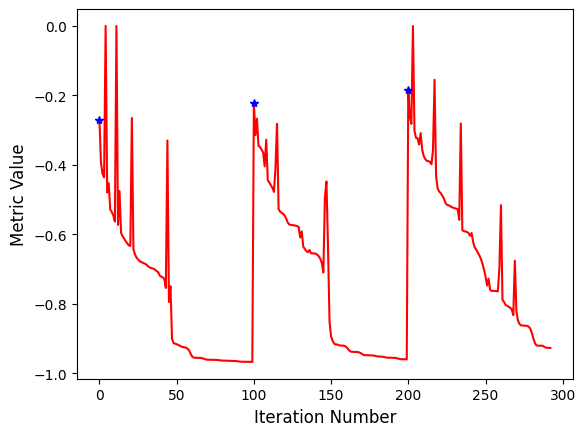

 92 =   -0.92670
 92 =   -0.92670
 92 =   -0.92670
 92 =   -0.92670
 92 =   -0.92670
 92 =   -0.92670
 92 =   -0.92670
 92 =   -0.92670
 92 =   -0.92670
 92 =   -0.92670
 92 =   -0.92670
 92 =   -0.92670
 92 =   -0.92670
-------
itk::simple::BSplineTransform
 BSplineTransform (0x15fbd10c0)
   RTTI typeinfo:   itk::BSplineTransform<double, 2u, 3u>
   Reference Count: 3
   Modified Time: 4260
   Debug: Off
   Object Name: 
   Observers: 
     none
   CoefficientImage: [ 0x15fbd11c0, 0x15fbd1380 ]
   TransformDomainOrigin: [-0.625, -0.625]
   TransformDomainPhysicalDimensions: [1280.25, 720.25]
   TransformDomainDirection: 1 0
0 1

   TransformDomainMeshSize: [1, 1]
   GridSize: [4, 4]
   GridOrigin: [-1280.88, -720.875]
   GridSpacing: [1280.25, 720.25]
   GridDirection: 1 0
0 1


Optimizer stop condition: LBFGSBOptimizerv4: Function tolerance reached after 93 iterations. The relative reduction of the cost function <= 2.22045e-09 = CostFunctionConvergenceFactor (1e+07) * machine precisio

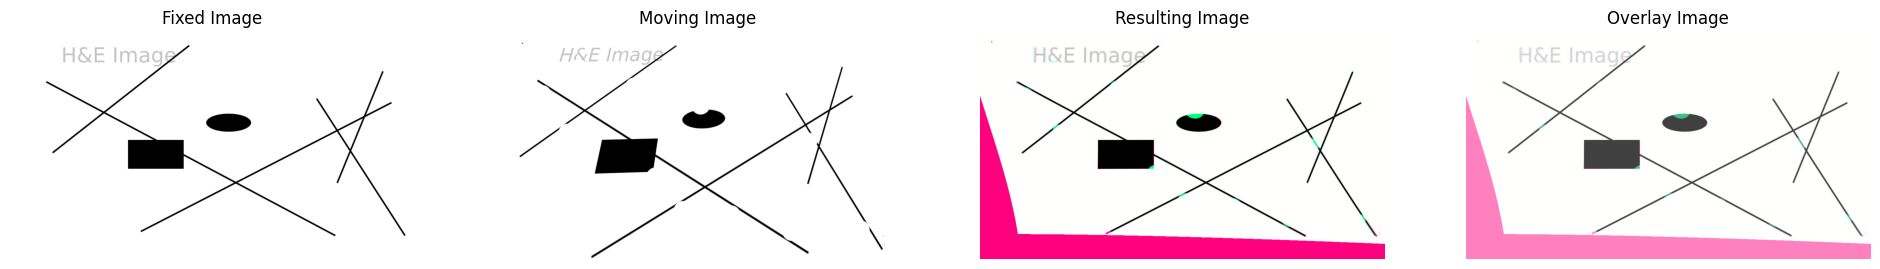

In [4]:
fixed_image_path = '/Users/linh/Downloads/example-toy-images-for-registration/data/image-target-image.png'
moving_image_path = '/Users/linh/Downloads/example-toy-images-for-registration/data/tiled/image-simple-1.png'
# Execute the function
result_images = register_images(fixed_image_path, moving_image_path)

# Call the display function
# display_images(fixed_image, moving_image, result_image)
display_images(result_images)

### Register with `image-harder-1.png`

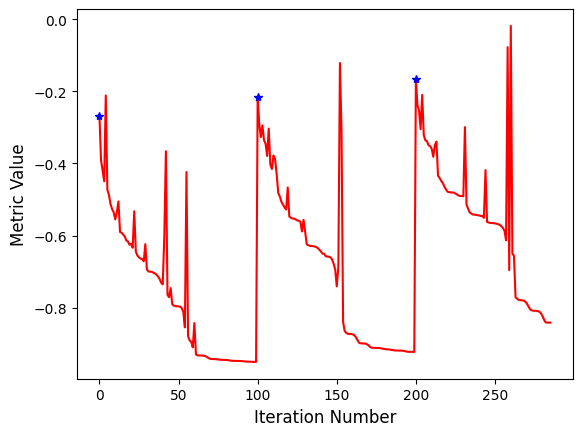

 85 =   -0.84177
 85 =   -0.84177
 85 =   -0.84177
 85 =   -0.84177
 85 =   -0.84177
 85 =   -0.84177
 85 =   -0.84177
 85 =   -0.84177
 85 =   -0.84177
 85 =   -0.84177
 85 =   -0.84177
-------
itk::simple::BSplineTransform
 BSplineTransform (0x15fbed1f0)
   RTTI typeinfo:   itk::BSplineTransform<double, 2u, 3u>
   Reference Count: 3
   Modified Time: 7217
   Debug: Off
   Object Name: 
   Observers: 
     none
   CoefficientImage: [ 0x15fbf0460, 0x15fbf8a80 ]
   TransformDomainOrigin: [-0.625, -0.625]
   TransformDomainPhysicalDimensions: [1280.25, 720.25]
   TransformDomainDirection: 1 0
0 1

   TransformDomainMeshSize: [1, 1]
   GridSize: [4, 4]
   GridOrigin: [-1280.88, -720.875]
   GridSpacing: [1280.25, 720.25]
   GridDirection: 1 0
0 1


Optimizer stop condition: LBFGSBOptimizerv4: Function tolerance reached after 86 iterations. The relative reduction of the cost function <= 2.22045e-09 = CostFunctionConvergenceFactor (1e+07) * machine precision (2.22045e-16).
 Iteration: 86
 M

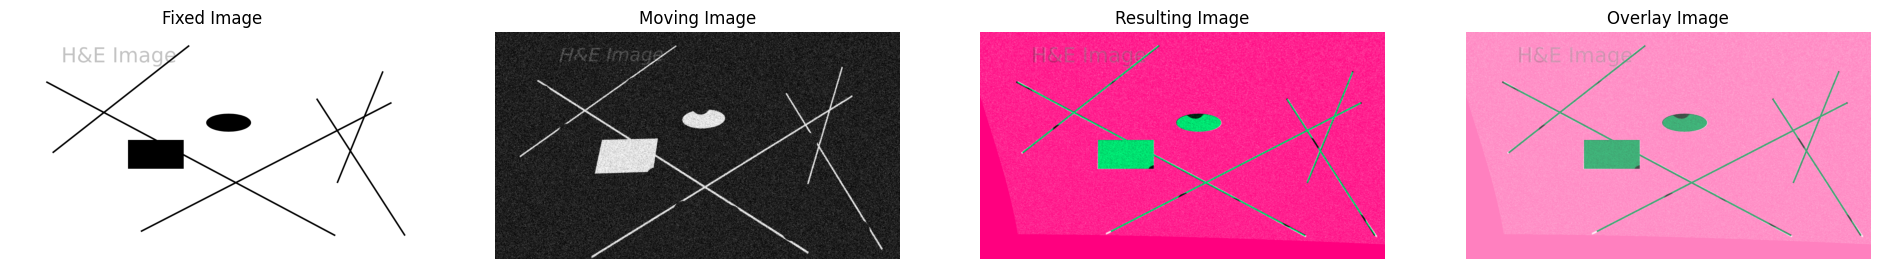

In [5]:
fixed_image_path = '/Users/linh/Downloads/example-toy-images-for-registration/data/image-target-image.png'
moving_image_path = '/Users/linh/Downloads/example-toy-images-for-registration/data/tiled/image-harder-1.png'

# Execute the function
result_images = register_images(fixed_image_path, moving_image_path)

# Call the display function
# display_images(fixed_image, moving_image, result_image)
display_images(result_images)

### Register with `image-harder-1-1.png`

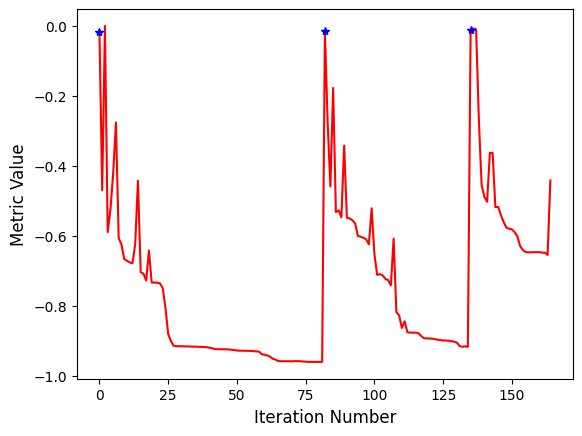

 29 =   -0.65379
 29 =   -0.65930
 29 =   -0.65936
 29 =   -0.65935
 29 =   -0.65937
 29 =   -0.65937
 29 =   -0.65937
 29 =   -0.65937
 29 =   -0.65937
 29 =   -0.65937
 29 =   -0.65937
 29 =   -0.65937
 29 =   -0.65937
 29 =   -0.65937
 29 =   -0.65937
 29 =   -0.65937
 29 =   -0.65937
 29 =   -0.65937
-------
itk::simple::BSplineTransform
 BSplineTransform (0x11de5b200)
   RTTI typeinfo:   itk::BSplineTransform<double, 2u, 3u>
   Reference Count: 3
   Modified Time: 10528
   Debug: Off
   Object Name: 
   Observers: 
     none
   CoefficientImage: [ 0x11e8d2940, 0x11e865670 ]
   TransformDomainOrigin: [-0.625, -0.625]
   TransformDomainPhysicalDimensions: [1280.25, 720.25]
   TransformDomainDirection: 1 0
0 1

   TransformDomainMeshSize: [1, 1]
   GridSize: [4, 4]
   GridOrigin: [-1280.88, -720.875]
   GridSpacing: [1280.25, 720.25]
   GridDirection: 1 0
0 1


Optimizer stop condition: LBFGSBOptimizerv4: Function tolerance reached after 30 iterations. The relative reduction of the c

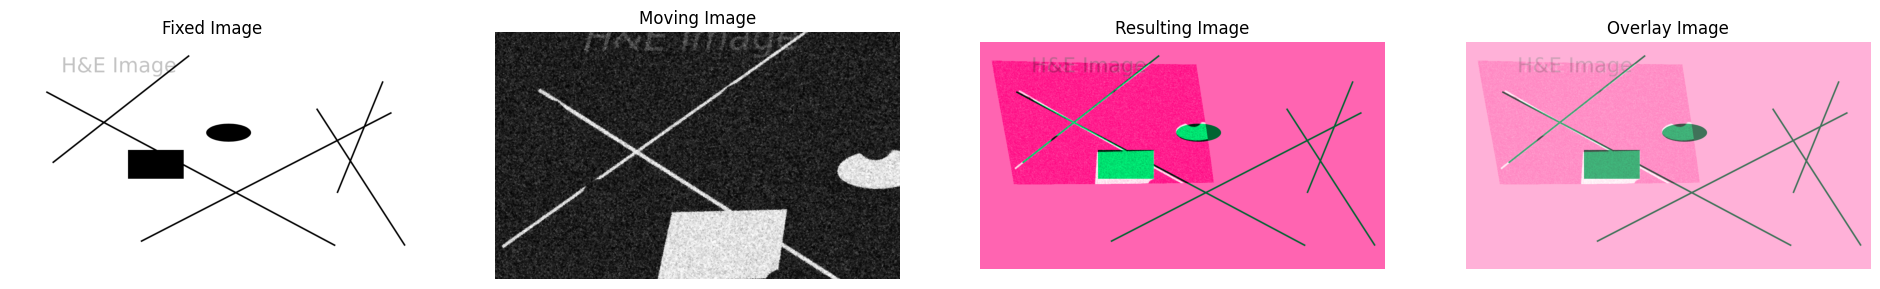

In [6]:
fixed_image_path = '/Users/linh/Downloads/example-toy-images-for-registration/data/image-target-image.png'
moving_image_path = '/Users/linh/Downloads/example-toy-images-for-registration/data/tiled/image-harder-1-1.png'

# Execute the function
result_images = register_images(fixed_image_path, moving_image_path)

# Call the display function
# display_images(fixed_image, moving_image, result_image)
display_images(result_images)

### Register with `image-simple-1-1.png`

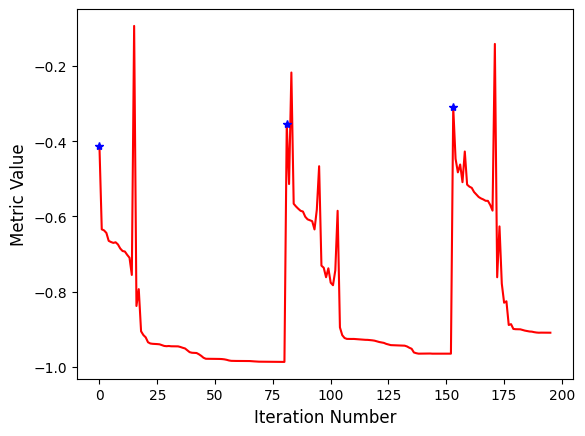

 42 =   -0.90963
 42 =   -0.90970
 42 =   -0.90970
 42 =   -0.90963
 42 =   -0.90970
 42 =   -0.90970
 42 =   -0.90963
 42 =   -0.90970
 42 =   -0.90970
 42 =   -0.90963
 42 =   -0.90970
 42 =   -0.90970
 42 =   -0.90970
-------
itk::simple::BSplineTransform
 BSplineTransform (0x12df8e9f0)
   RTTI typeinfo:   itk::BSplineTransform<double, 2u, 3u>
   Reference Count: 3
   Modified Time: 13804
   Debug: Off
   Object Name: 
   Observers: 
     none
   CoefficientImage: [ 0x15fbd6b20, 0x15fbe6870 ]
   TransformDomainOrigin: [-0.625, -0.625]
   TransformDomainPhysicalDimensions: [1280.25, 720.25]
   TransformDomainDirection: 1 0
0 1

   TransformDomainMeshSize: [1, 1]
   GridSize: [4, 4]
   GridOrigin: [-1280.88, -720.875]
   GridSpacing: [1280.25, 720.25]
   GridDirection: 1 0
0 1


Optimizer stop condition: LBFGSBOptimizerv4: Function tolerance reached after 43 iterations. The relative reduction of the cost function <= 2.22045e-09 = CostFunctionConvergenceFactor (1e+07) * machine precisi

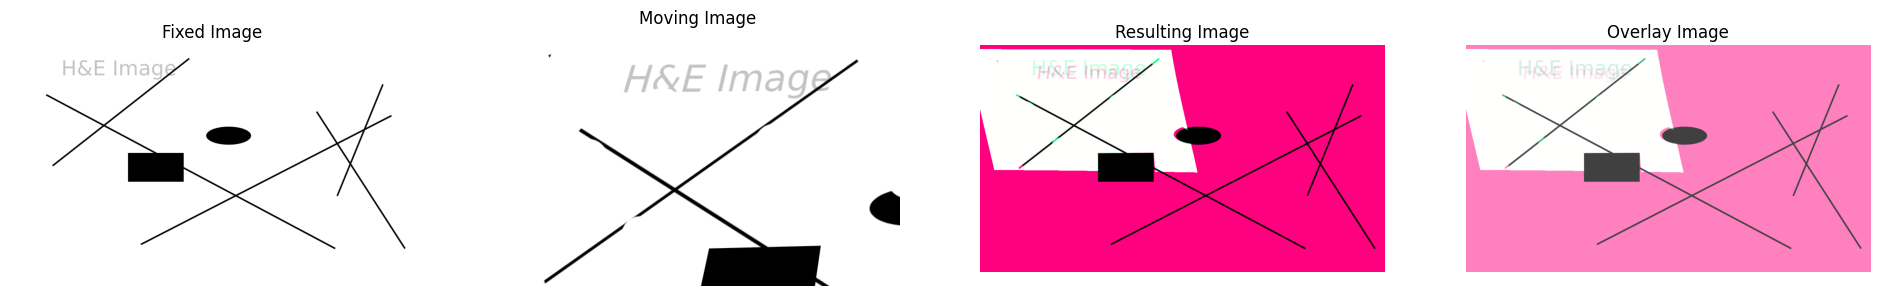

In [7]:
fixed_image_path = '/Users/linh/Downloads/example-toy-images-for-registration/data/image-target-image.png'
moving_image_path = '/Users/linh/Downloads/example-toy-images-for-registration/data/tiled/image-simple-1-1.png'

# Execute the function
result_images = register_images(fixed_image_path, moving_image_path)

# Call the display function
# display_images(fixed_image, moving_image, result_image)
display_images(result_images)

### Register with `image-simple-1-2.png`

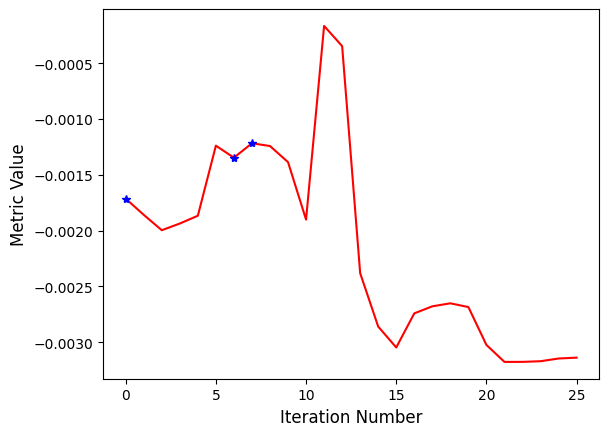

 19 =   -0.00321
 19 =   -0.00321
 19 =   -0.00321
 19 =   -0.00321
 19 =   -0.00321
 19 =   -0.00321
 19 =   -0.00321
 19 =   -0.00321
 19 =   -0.00321
 19 =   -0.00321
 19 =   -0.00321
 19 =   -0.00321
-------
itk::simple::BSplineTransform
 BSplineTransform (0x11eb1f590)
   RTTI typeinfo:   itk::BSplineTransform<double, 2u, 3u>
   Reference Count: 3
   Modified Time: 16114
   Debug: Off
   Object Name: 
   Observers: 
     none
   CoefficientImage: [ 0x11eb22d00, 0x11eb17490 ]
   TransformDomainOrigin: [-0.625, -0.625]
   TransformDomainPhysicalDimensions: [1280.25, 720.25]
   TransformDomainDirection: 1 0
0 1

   TransformDomainMeshSize: [1, 1]
   GridSize: [4, 4]
   GridOrigin: [-1280.88, -720.875]
   GridSpacing: [1280.25, 720.25]
   GridDirection: 1 0
0 1


Optimizer stop condition: LBFGSBOptimizerv4: Function tolerance reached after 20 iterations. The relative reduction of the cost function <= 2.22045e-09 = CostFunctionConvergenceFactor (1e+07) * machine precision (2.22045e-16).

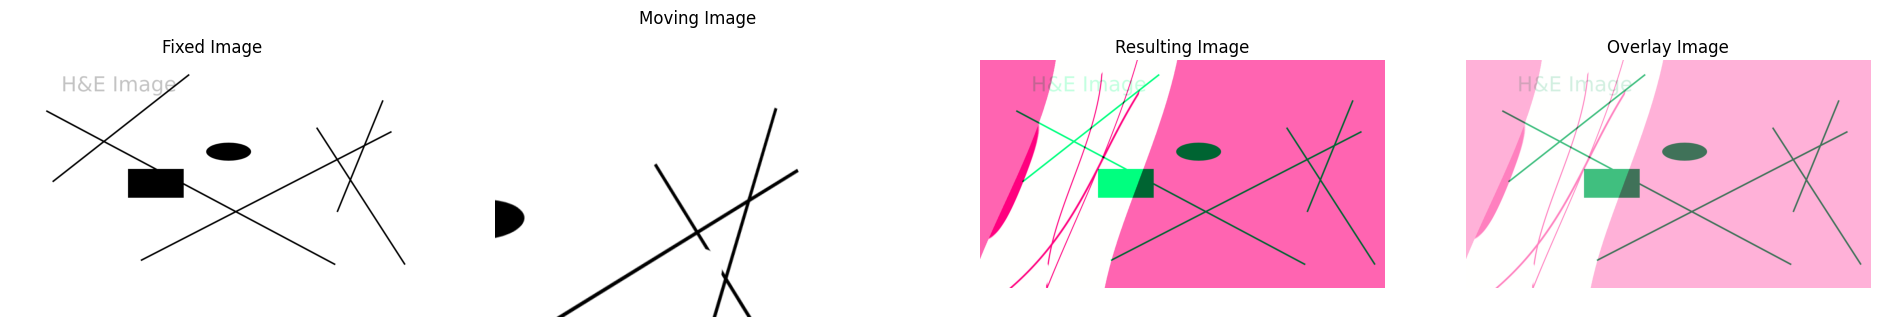

In [8]:
fixed_image_path = '/Users/linh/Downloads/example-toy-images-for-registration/data/image-target-image.png'
moving_image_path = '/Users/linh/Downloads/example-toy-images-for-registration/data/tiled/image-simple-1-2.png'

# Execute the function
result_images = register_images(fixed_image_path, moving_image_path)

# Call the display function
# display_images(fixed_image, moving_image, result_image)
display_images(result_images)

#### If I manually crop the a quarter of the target image and process the registration again

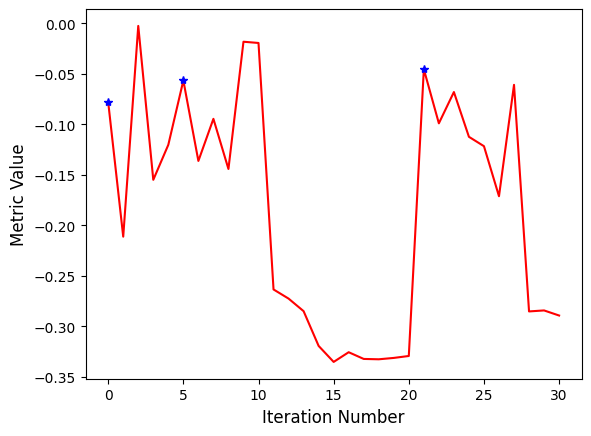

  9 =   -0.29077
  9 =   -0.29081
  9 =   -0.29081
  9 =   -0.29081
  9 =   -0.29081
  9 =   -0.29081
  9 =   -0.29081
  9 =   -0.29081
  9 =   -0.29081
  9 =   -0.29081
  9 =   -0.29081
  9 =   -0.29081
  9 =   -0.29081
-------
itk::simple::BSplineTransform
 BSplineTransform (0x103f0e5d0)
   RTTI typeinfo:   itk::BSplineTransform<double, 2u, 3u>
   Reference Count: 3
   Modified Time: 18466
   Debug: Off
   Object Name: 
   Observers: 
     none
   CoefficientImage: [ 0x103f0e6d0, 0x103f0e890 ]
   TransformDomainOrigin: [-0.625, -0.625]
   TransformDomainPhysicalDimensions: [599.25, 483.25]
   TransformDomainDirection: 1 0
0 1

   TransformDomainMeshSize: [1, 1]
   GridSize: [4, 4]
   GridOrigin: [-599.875, -483.875]
   GridSpacing: [599.25, 483.25]
   GridDirection: 1 0
0 1


Optimizer stop condition: LBFGSBOptimizerv4: Function tolerance reached after 10 iterations. The relative reduction of the cost function <= 2.22045e-09 = CostFunctionConvergenceFactor (1e+07) * machine precision

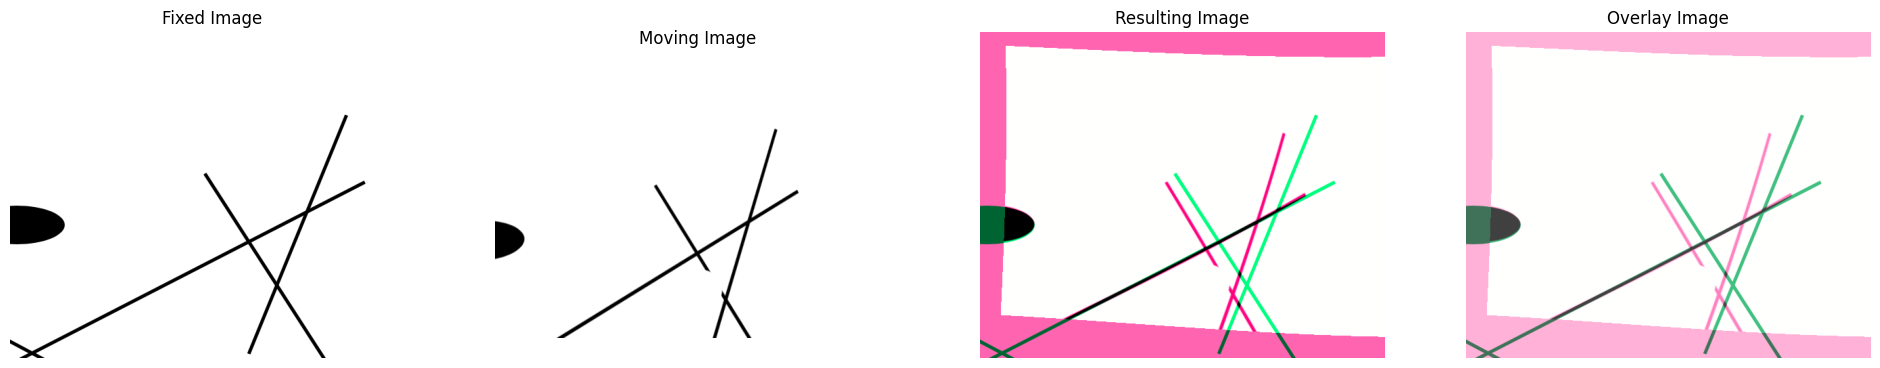

In [9]:
fixed_image_path = '/Users/linh/Downloads/example-toy-images-for-registration/data/image-target-1-2.png'
moving_image_path = '/Users/linh/Downloads/example-toy-images-for-registration/data/tiled/image-simple-1-2.png'

# Execute the function
result_images = register_images(fixed_image_path, moving_image_path)

# Call the display function
# display_images(fixed_image, moving_image, result_image)
display_images(result_images)

### Register with `image-simple-1-3.png`

/Users/linh/miniforge3/envs/spy/lib/python3.10/site-packages/matplotlib/axes/_base.py:2923: RuntimeWarning: overflow encountered in scalar add
  x0, x1 = inverse_trans.transform([x0t - delta, x1t + delta])


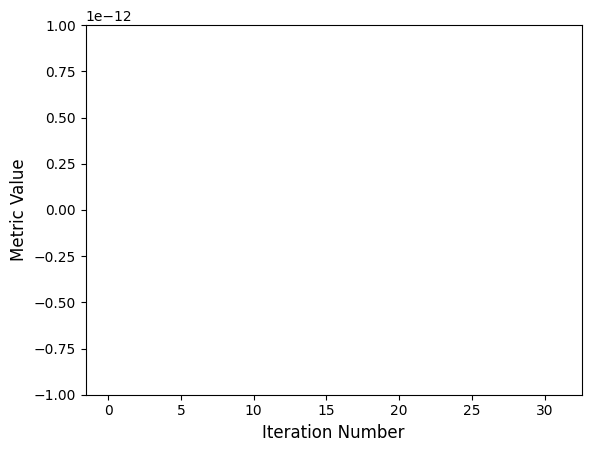

  6 =   -0.00185
  6 =   -0.00185
-------
itk::simple::BSplineTransform
 BSplineTransform (0x103f0ada0)
   RTTI typeinfo:   itk::BSplineTransform<double, 2u, 3u>
   Reference Count: 3
   Modified Time: 20905
   Debug: Off
   Object Name: 
   Observers: 
     none
   CoefficientImage: [ 0x103f0aea0, 0x103f0a410 ]
   TransformDomainOrigin: [-0.625, -0.625]
   TransformDomainPhysicalDimensions: [1280.25, 720.25]
   TransformDomainDirection: 1 0
0 1

   TransformDomainMeshSize: [1, 1]
   GridSize: [4, 4]
   GridOrigin: [-1280.88, -720.875]
   GridSpacing: [1280.25, 720.25]
   GridDirection: 1 0
0 1


Optimizer stop condition: LBFGSBOptimizerv4: Function tolerance reached after 7 iterations. The relative reduction of the cost function <= 2.22045e-09 = CostFunctionConvergenceFactor (1e+07) * machine precision (2.22045e-16).
 Iteration: 7
 Metric value: -0.0018493542629647493


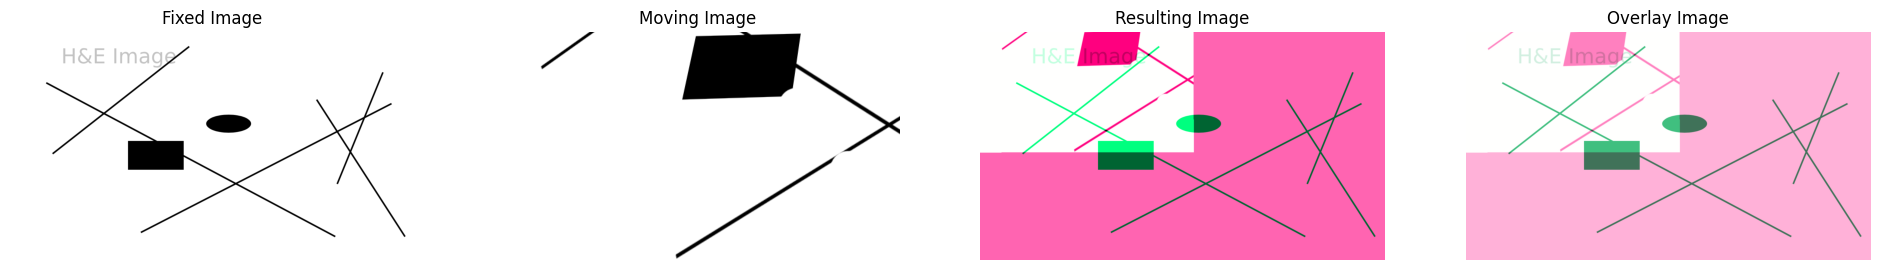

In [10]:
fixed_image_path = '/Users/linh/Downloads/example-toy-images-for-registration/data/image-target-image.png'
moving_image_path = '/Users/linh/Downloads/example-toy-images-for-registration/data/tiled/image-simple-1-3.png'

# Execute the function
result_images = register_images(fixed_image_path, moving_image_path)

# Call the display function
# display_images(fixed_image, moving_image, result_image)
display_images(result_images)

#### If I manually crop the a quarter of the target image and process the registration again

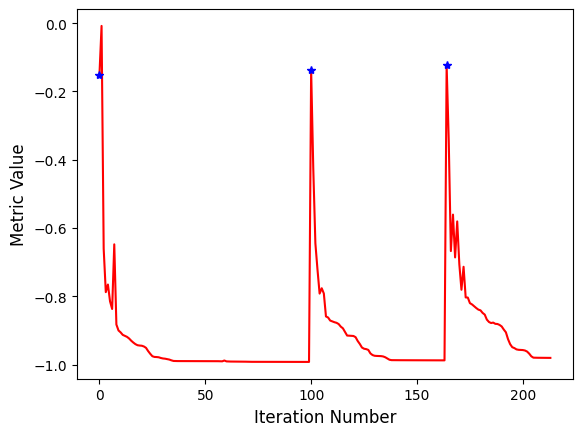

 49 =   -0.98021
 49 =   -0.98021
 49 =   -0.98021
 49 =   -0.98021
 49 =   -0.98021
 49 =   -0.98021
 49 =   -0.98021
 49 =   -0.98021
 49 =   -0.98021
 49 =   -0.98021
 49 =   -0.98021
-------
itk::simple::BSplineTransform
 BSplineTransform (0x10508da90)
   RTTI typeinfo:   itk::BSplineTransform<double, 2u, 3u>
   Reference Count: 3
   Modified Time: 23611
   Debug: Off
   Object Name: 
   Observers: 
     none
   CoefficientImage: [ 0x105087460, 0x105087620 ]
   TransformDomainOrigin: [-0.625, -0.625]
   TransformDomainPhysicalDimensions: [646.25, 308.25]
   TransformDomainDirection: 1 0
0 1

   TransformDomainMeshSize: [1, 1]
   GridSize: [4, 4]
   GridOrigin: [-646.875, -308.875]
   GridSpacing: [646.25, 308.25]
   GridDirection: 1 0
0 1


Optimizer stop condition: LBFGSBOptimizerv4: Function tolerance reached after 50 iterations. The relative reduction of the cost function <= 2.22045e-09 = CostFunctionConvergenceFactor (1e+07) * machine precision (2.22045e-16).
 Iteration: 50
 Me

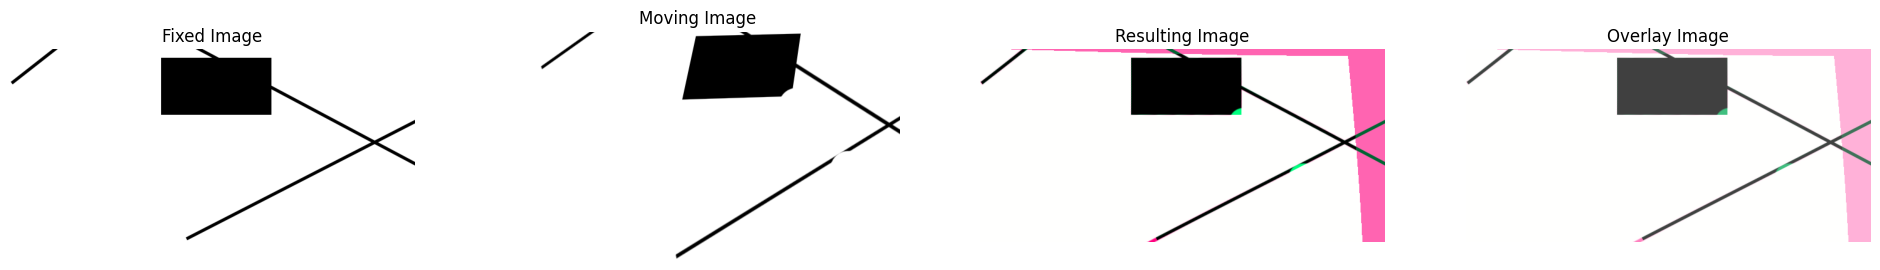

In [11]:
fixed_image_path = '/Users/linh/Downloads/example-toy-images-for-registration/data/image-target-1-3.png'
moving_image_path = '/Users/linh/Downloads/example-toy-images-for-registration/data/tiled/image-simple-1-3.png'

# Execute the function
result_images = register_images(fixed_image_path, moving_image_path)

# Call the display function
# display_images(fixed_image, moving_image, result_image)
display_images(result_images)

### Register with `image-simple-1-4.png`

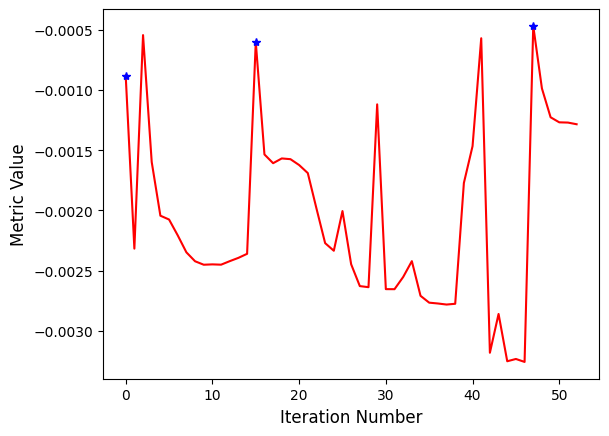

  5 =   -0.00128
  5 =   -0.00129
  5 =   -0.00129
  5 =   -0.00129
  5 =   -0.00129
  5 =   -0.00129
  5 =   -0.00129
  5 =   -0.00129
  5 =   -0.00129
  5 =   -0.00129
  5 =   -0.00129
  5 =   -0.00129
  5 =   -0.00129
  5 =   -0.00129
-------
itk::simple::BSplineTransform
 BSplineTransform (0x104e3dfb0)
   RTTI typeinfo:   itk::BSplineTransform<double, 2u, 3u>
   Reference Count: 3
   Modified Time: 26293
   Debug: Off
   Object Name: 
   Observers: 
     none
   CoefficientImage: [ 0x104e43c10, 0x104e57d40 ]
   TransformDomainOrigin: [-0.625, -0.625]
   TransformDomainPhysicalDimensions: [1280.25, 720.25]
   TransformDomainDirection: 1 0
0 1

   TransformDomainMeshSize: [1, 1]
   GridSize: [4, 4]
   GridOrigin: [-1280.88, -720.875]
   GridSpacing: [1280.25, 720.25]
   GridDirection: 1 0
0 1


Optimizer stop condition: LBFGSBOptimizerv4: Function tolerance reached after 6 iterations. The relative reduction of the cost function <= 2.22045e-09 = CostFunctionConvergenceFactor (1e+07) *

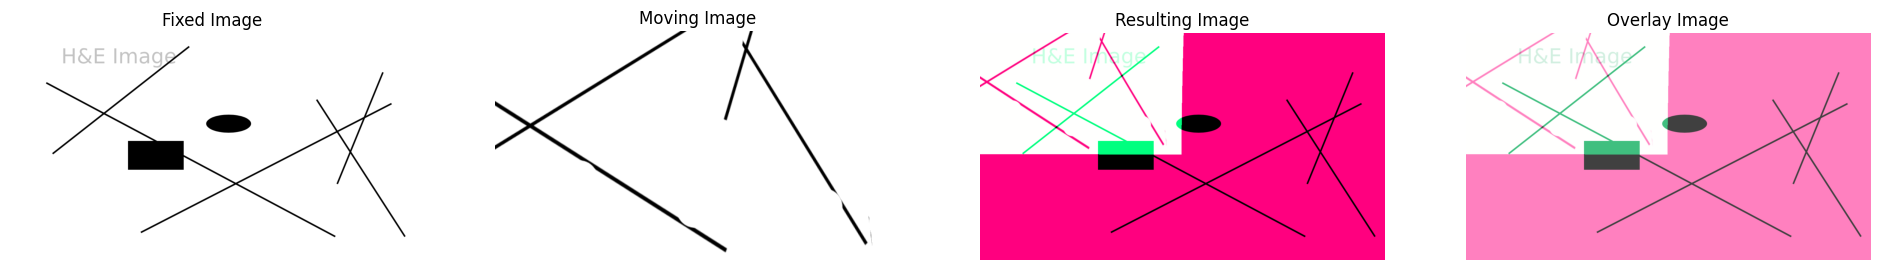

In [12]:
fixed_image_path = '/Users/linh/Downloads/example-toy-images-for-registration/data/image-target-image.png'
moving_image_path = '/Users/linh/Downloads/example-toy-images-for-registration/data/tiled/image-simple-1-4.png'

# Execute the function
result_images = register_images(fixed_image_path, moving_image_path)

# Call the display function
# display_images(fixed_image, moving_image, result_image)
display_images(result_images)

#### If I manually crop the a quarter of the target image and process the registration again

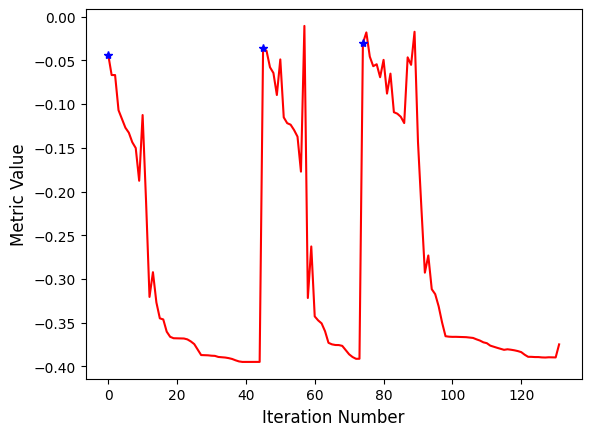

 57 =   -0.38956
 57 =   -0.39004
 57 =   -0.39005
 57 =   -0.39005
 57 =   -0.39005
 57 =   -0.39005
 57 =   -0.39005
 57 =   -0.39005
 57 =   -0.39005
 57 =   -0.39005
 57 =   -0.39005
-------
itk::simple::BSplineTransform
 BSplineTransform (0x105086990)
   RTTI typeinfo:   itk::BSplineTransform<double, 2u, 3u>
   Reference Count: 3
   Modified Time: 28894
   Debug: Off
   Object Name: 
   Observers: 
     none
   CoefficientImage: [ 0x105087dc0, 0x105087f80 ]
   TransformDomainOrigin: [-0.625, -0.625]
   TransformDomainPhysicalDimensions: [601.25, 309.25]
   TransformDomainDirection: 1 0
0 1

   TransformDomainMeshSize: [1, 1]
   GridSize: [4, 4]
   GridOrigin: [-601.875, -309.875]
   GridSpacing: [601.25, 309.25]
   GridDirection: 1 0
0 1


Optimizer stop condition: LBFGSBOptimizerv4: Function tolerance reached after 58 iterations. The relative reduction of the cost function <= 2.22045e-09 = CostFunctionConvergenceFactor (1e+07) * machine precision (2.22045e-16).
 Iteration: 58
 Me

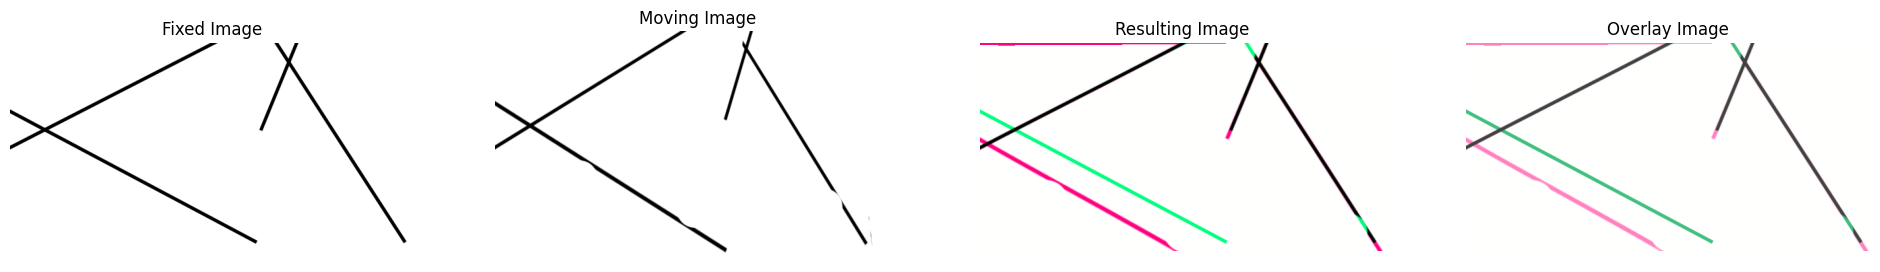

In [13]:
fixed_image_path = '/Users/linh/Downloads/example-toy-images-for-registration/data/image-target-1-4.png'
moving_image_path = '/Users/linh/Downloads/example-toy-images-for-registration/data/tiled/image-simple-1-4.png'

# Execute the function
result_images = register_images(fixed_image_path, moving_image_path)

# Call the display function
# display_images(fixed_image, moving_image, result_image)
display_images(result_images)

### Now, let try the unsuccessfully registered images using `imreg_dft` with the `similarity` function
NOTE: The library has only two functions for a registration process:`similarity` and `translation`

In [14]:
def preprocess_images(img):
    if img.size == 0 or np.all(img == 0):
        print("Warning: Image is empty. Proceeding with a placeholder.")
        return np.zeros((256, 256))  # Placeholder for empty images
    # Check if the image has 4 channels (RGBA), then discard the alpha channel
    # Check if the image is already in grayscale
    if img.ndim == 2 or (img.ndim == 3 and img.shape[2] == 1):
        gray_img = img
    else:
        # Assuming the image is RGB or RGBA
        if img.shape[-1] == 4:  # RGBA
            img = img[..., :3]  # Discard the alpha channel
        gray_img = rgb2gray(img)
    

    gray_img = gray_img.astype(np.float32)
    gray_img = np.clip(gray_img, a_min=np.mean(gray_img) - 5 * np.std(gray_img), a_max=np.mean(gray_img) + 5 * np.std(gray_img))
    eq_img = equalize_adapthist(gray_img / gray_img.max())
    return eq_img


def pad_images_to_same_size(img1, img2):
    # Determine the maximum dimensions
    y_max = max(img1.shape[0], img2.shape[0])
    x_max = max(img1.shape[1], img2.shape[1])

    # Initialize padding for grayscale images
    pad_width1 = ((0, y_max - img1.shape[0]), (0, x_max - img1.shape[1]))
    pad_width2 = ((0, y_max - img2.shape[0]), (0, x_max - img2.shape[1]))

    # Adjust for color images (3D arrays)
    if img1.ndim == 3:
        pad_width1 = pad_width1 + ((0, 0),)  # Add padding for the color dimension
    if img2.ndim == 3:
        pad_width2 = pad_width2 + ((0, 0),)  # Add padding for the color dimension
    
    # Apply padding
    img1_padded = np.pad(img1, pad_width1, mode='constant', constant_values=0)
    img2_padded = np.pad(img2, pad_width2, mode='constant', constant_values=0)

    return img1_padded, img2_padded


def show_section(img, title="", save_path=None):
    """
    Displays and optionally saves a chosen section of an image.
    """
    img = preprocess_images(img)
    
    plt.imshow(img, cmap='inferno')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title(title)
    plt.show()
    
    if save_path:
        plt.savefig(save_path)  # Save the displayed image to a file

def register(img0, img1):
    """
    Register two images using imreg_dft library and display/save the results.
    """
    result = ird.similarity(img0, img1, numiter=3)

    # Visualize the results
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(img1, cmap='gray')
    axs[0].set_title('Target Image')
    axs[0].axis('off')

    axs[1].imshow(img0, cmap='gray')
    axs[1].set_title('Tiled Image')
    axs[1].axis('off')

    overlay = np.dstack((img0, np.zeros_like(img1), img1))
    axs[2].imshow(overlay, cmap='gray')
    axs[2].set_title('Transformed Tiled Image')
    axs[2].axis('off')

    plt.tight_layout()
    plt.show()
    fig.savefig("registered_images_output.png")  # Save the figure with all subplots
    return result



def find_origin(
        #tile_name: str,
        tile_img: np.ndarray,
        target_img: np.ndarray,
        x_start: int,
        y_start: int,
        border: float = 0.5,
    ):
        """
        Register first tile and set anchor parameters

        tile_name: mIF tile name
        x_start: X coordinate in Hematoxylin image
        y_start: Y coordinate in Hematoxylin image
        border: percentage of height/width defining the area around the mIF tile that is added before registration
        """

        tile_img = preprocess_images(tile_img)
        target_img= preprocess_images(target_img)
        print(f"Initial tile image shape: {tile_img.shape}")
        print(f"Initial target image shape: {target_img.shape}")

        tile_img, target_img = pad_images_to_same_size(tile_img, target_img)

        y_border = int(tile_img.shape[0] * border)
        x_border = int(tile_img.shape[1] * border)
        tile_img_with_borders = cv2.copyMakeBorder(
            tile_img,
            y_border,
            y_border,
            x_border,
            x_border,
            cv2.BORDER_CONSTANT,
            value=[0, 0, 0],
        )
        y_size, x_size = tile_img_with_borders.shape

        max_y_end, max_x_end = target_img.shape

        x0 = x_start - x_border
        x1 = x0 + x_size
        y0 = y_start - y_border
        y1 = y0 + y_size

        if y0 < 0:
            top = -y0
            y0 = 0
        else:
            top = 0

        if y1 > max_y_end:
            bottom = y1 - max_y_end
            y1 = max_y_end
        else:
            bottom = 0

        if x0 < 0:
            left = -x0
            x0 = 0
        else:
            left = 0

        if x1 > max_x_end:
            right = x1 - max_x_end
            x1 = max_x_end
        else:
            right = 0

        target_img_region = target_img[y0:y1, x0:x1].astype(np.float32)
        target_img_region_with_borders = cv2.copyMakeBorder(
            target_img_region, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[0, 0, 0]
        )
        # show results
        # assert tile_img_with_borders.shape == target_img_region_with_borders.shape
        # Adjusted assertion to compare shapes, accounting for potential differences in channels
        print("Tile image shape:", tile_img_with_borders.shape)
        print("Target image shape:", target_img_region_with_borders.shape)
        # assert tile_img_with_borders.shape[:2] == target_img_region_with_borders.shape[:2], "The spatial dimensions do not match."
        assert tile_img_with_borders.shape == target_img_region_with_borders.shape, "The images do not have the same shape after padding."
        assert tile_img_with_borders.ndim == target_img_region_with_borders.ndim, "Dimension mismatch."
        print(f"Post-padding tile image shape: {tile_img_with_borders.shape}")
        print(f"Post-padding target image shape: {target_img_region_with_borders.shape}")

        show_section(tile_img_with_borders, "Tile with borders")
        show_section(target_img_region_with_borders, "Region to register")

        result = register(tile_img_with_borders, target_img_region_with_borders)
        # result = register_and_save(tile_img_with_borders, target_img_region_with_borders, save_path="./data/x.png")
        print(result) 
        return {
            'tvec': np.array([0, 0]),
            'success': 0,
            'angle': 0,
            'scale': 1,
            'Dscale': 0,
            'Dangle': 0,
            'Dt': 0,
            'timg': np.zeros_like(tile_img)  # Assuming tile_img is available in the context
        }


#### Register `image-harder-1-1`

Initial tile image shape: (380, 621)
Initial target image shape: (720, 1280)
Tile image shape: (1440, 2560)
Target image shape: (1440, 2560)
Post-padding tile image shape: (1440, 2560)
Post-padding target image shape: (1440, 2560)


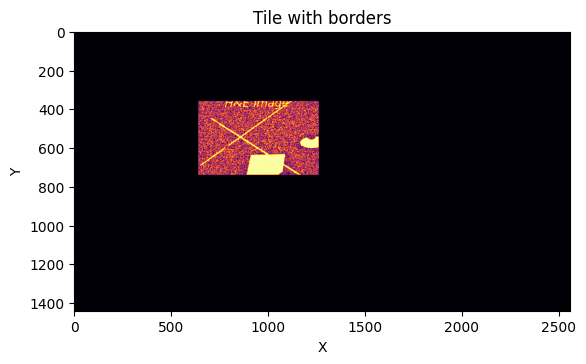

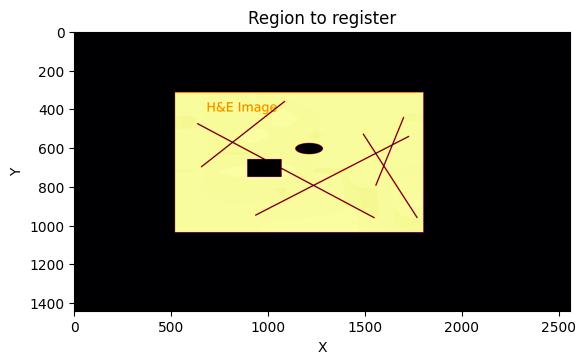

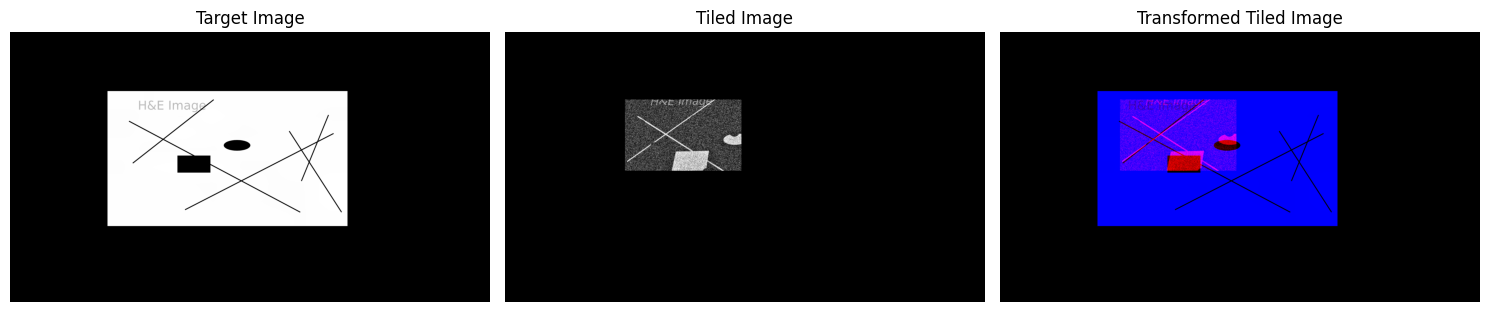

{'tvec': array([-146.12793499, -294.03987533]), 'success': 0.02190512654973938, 'angle': -0.005451194910904178, 'scale': 0.5286641103571742, 'Dscale': 0.00034503955411254263, 'Dangle': 0.017578125, 'Dt': 0.25, 'timg': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)}


In [18]:
tile_img_path="/Users/linh/Downloads/example-toy-images-for-registration/data/tiled/image-harder-1-1.png"
target_img_path="/Users/linh/Downloads/example-toy-images-for-registration/data/image-target-image.png"
tiled_image = imread(tile_img_path).astype(np.float32)
target_image = imread(target_img_path).astype(np.float32)

 
# tiled_image = rgb2gray(imread(tile_img_path)).astype(np.float32)
# target_image = rgb2gray(imread(target_img_path)).astype(np.float32) 

approx_location = (150, 400)  # y, x coordinates
search_area_size = 600

result = find_origin(tile_img=tiled_image,
        target_img=target_image,
        x_start=120,
        y_start=45,
        border=0.5,)
some_success_threshold = 0.001
if result['success'] > some_success_threshold:
    # Proceed with using the result
    transformed_image = result['timg']
    # Display the transformed image
    plt.figure(figsize=(8, 6))
    plt.imshow(transformed_image, cmap='gray')
    plt.title("Transformed Image")
    plt.axis('off')
    plt.show()

#### Register `image-simple-1-2`

Initial tile image shape: (421, 596)
Initial target image shape: (720, 1280)
Tile image shape: (1440, 2560)
Target image shape: (1440, 2560)
Post-padding tile image shape: (1440, 2560)
Post-padding target image shape: (1440, 2560)


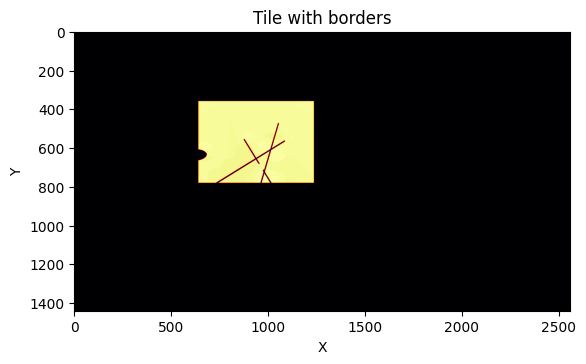

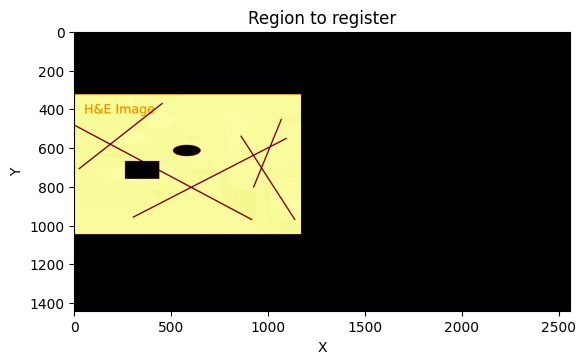

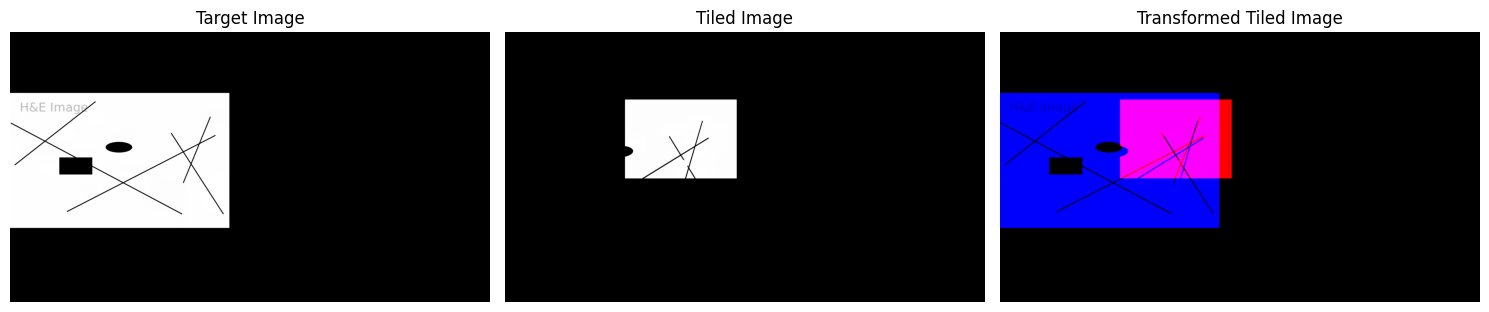

{'tvec': array([ -155.63575743, -1054.08266721]), 'success': 0.09405841388872298, 'angle': 179.99984165312173, 'scale': 0.5841542946618823, 'Dscale': 0.00038125594950428525, 'Dangle': 0.017578125, 'Dt': 0.25, 'timg': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)}


In [15]:

tile_img_path="/Users/linh/Downloads/example-toy-images-for-registration/data/tiled/image-simple-1-2.png"
target_img_path="/Users/linh/Downloads/example-toy-images-for-registration/data/image-target-image.png"

tiled_image = imread(tile_img_path).astype(np.float32)
target_image = imread(target_img_path).astype(np.float32)

result = find_origin(tile_img=tiled_image,
        target_img=target_image,
        x_start=750,
        y_start=35,
        border=0.5,)
some_success_threshold = 0.001
if result['success'] > some_success_threshold:
    # Proceed with using the result
    transformed_image = result['timg']
    # Display the transformed image
    plt.figure(figsize=(8, 6))
    plt.imshow(transformed_image, cmap='gray')
    plt.title("Transformed Image")
    plt.axis('off')
    plt.show()


#### Register `image-simple-1-3`

Initial tile image shape: (385, 682)
Initial target image shape: (720, 1280)
Tile image shape: (1440, 2560)
Target image shape: (1440, 2560)
Post-padding tile image shape: (1440, 2560)
Post-padding target image shape: (1440, 2560)


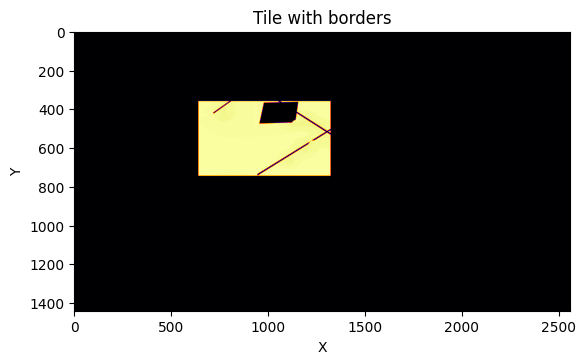

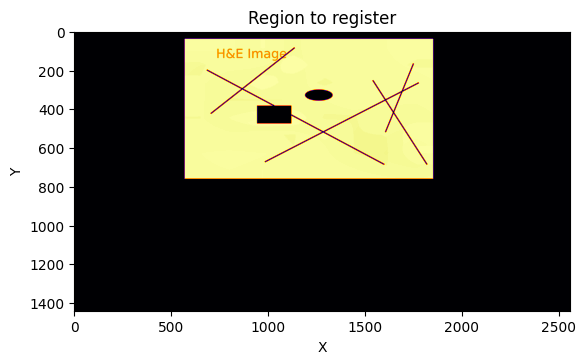

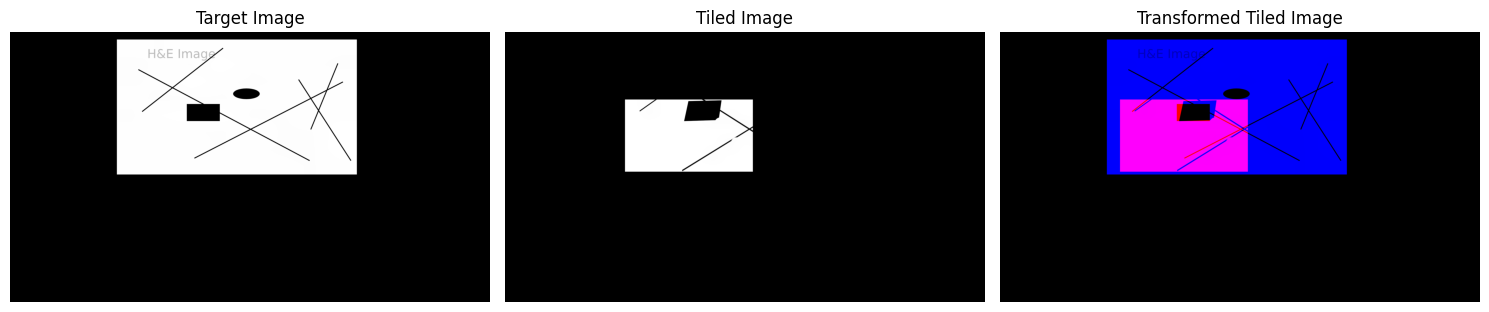

{'tvec': array([ 275.98228886, -294.02514974]), 'success': 0.04605654529366702, 'angle': 0.050059692813448464, 'scale': 1.0261805459572897, 'Dscale': 0.0006697501704378065, 'Dangle': 0.017578125, 'Dt': 0.25, 'timg': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)}


In [16]:
tile_img_path="/Users/linh/Downloads/example-toy-images-for-registration/data/tiled/image-simple-1-3.png"
target_img_path="/Users/linh/Downloads/example-toy-images-for-registration/data/image-target-image.png"
tiled_image = imread(tile_img_path).astype(np.float32)
target_image = imread(target_img_path).astype(np.float32)

result = find_origin(tile_img=tiled_image,
        target_img=target_image,
        x_start=70,
        y_start=320,
        border=0.5,)
some_success_threshold = 0.001
if result['success'] > some_success_threshold:
    # Proceed with using the result
    transformed_image = result['timg']
    # Display the transformed image
    plt.figure(figsize=(8, 6))
    plt.imshow(transformed_image, cmap='gray')
    plt.title("Transformed Image")
    plt.axis('off')
    plt.show()

#### Register `image-simple-1-4`

Initial tile image shape: (385, 675)
Initial target image shape: (720, 1280)
Tile image shape: (1440, 2560)
Target image shape: (1440, 2560)
Post-padding tile image shape: (1440, 2560)
Post-padding target image shape: (1440, 2560)


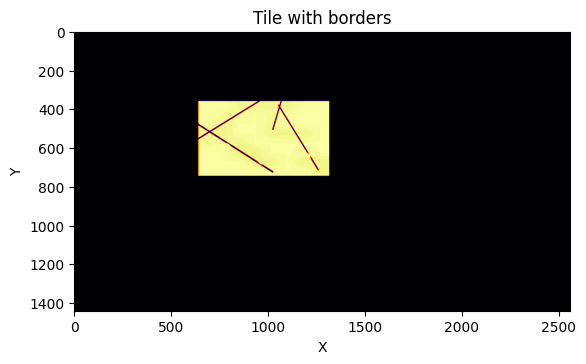

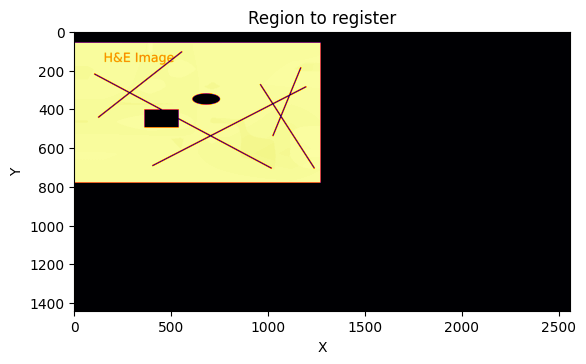

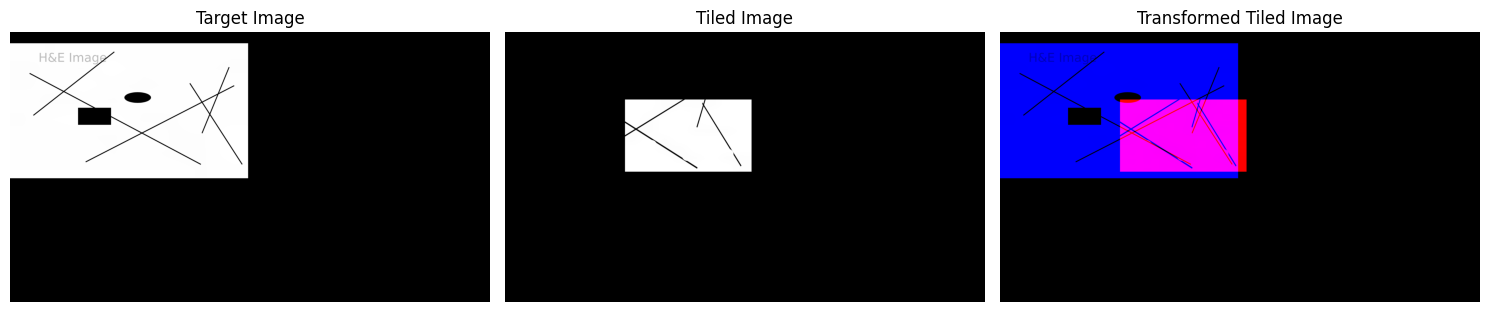

{'tvec': array([-6.99151927, 44.86712592]), 'success': 0.10843904520208586, 'angle': 0.0014136719156283561, 'scale': 0.5349214758382396, 'Dscale': 0.0003491235056295982, 'Dangle': 0.017578125, 'Dt': 0.25, 'timg': array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)}


In [17]:
tile_img_path="/Users/linh/Downloads/example-toy-images-for-registration/data/tiled/image-simple-1-4.png"
target_img_path="/Users/linh/Downloads/example-toy-images-for-registration/data/image-target-image.png"
tiled_image = imread(tile_img_path).astype(np.float32)
target_image = imread(target_img_path).astype(np.float32)

result = find_origin(tile_img=tiled_image,
        target_img=target_image,
        x_start=650,
        y_start=300,
        border=0.5,)
some_success_threshold = 0.001
if result['success'] > some_success_threshold:
    # Proceed with using the result
    transformed_image = result['timg']
    # Display the transformed image
    plt.figure(figsize=(20, 20))
    plt.imshow(transformed_image, cmap='gray')
    plt.title("Transformed Image")
    plt.axis('off')
    plt.show()

## Brief Conclusions:

#### 1. **Limited Generalizability:** The current approach may not be suitable for overall images or generalizable to different datasets. Algorithms that perform well on specific image characteristics might not work well on all images.
#### 2. **Manual Parameter Tuning:**  While manually adjusting parameters for each transformation algorithm can improve registration metrics for a specific case, it's a time-consuming and non-scalable approach. Consider exploring automated optimization techniques.
#### 3. **Multi-Step Registration:**  A multi-step registration process can be beneficial. For example, using `imreg_dft` for initial coarse alignment followed by refinement with `simpleITK` can lead to improved results. However, the optimal workflow might depend on the specific image characteristics and registration requirements.
